# CS 480/680 assignment 4

Tips:
- Please save a copy of this notebook to avoid losing your changes.
- Debug your code and ensure that it can run.
- Save the output of each cell. Failure to do so may result in your coding questions not being graded.
- To accelerate the training time, you can choose 'Runtime' -> 'Change runtime type' -> 'Hardware accelerator' and set 'Hardware accelerator' to 'GPU'.
- Your grade is independent of the accuracy of your models. Your grade will depend on the correctness of your code and implementation.

Tips for submission:
- Do not change the order of the problems.
- Select 'Runtime' -> 'Run all' to run all cells and generate a final "gradable" version of your notebook and save your ipynb file.
- Also use 'File' -> 'Print' and then print your report from your browser into a PDF file.

##Question1 - Adversarial Training (55 points)

In this assignment, you are supposed to train a model using limited data that, in addition to generalization, also possesses good robustness.


You can add any extra libraries that you need in this cell.

In [ ]:
import torch
import torchvision
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision import transforms
from collections import Counter
import matplotlib.pyplot as plt
import torchvision.models as models
from tqdm import tqdm
import torch.nn as nn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import random
from torch.utils.data import DataLoader

In [ ]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

###Q1.1 Load Data (5 points)

In this question, you are going to use CIFAR-10 dataset. First, load this dataset, then split 20% of the data for training and the rest for validation. Make sure to maintain class balance during the split.

In [13]:
Train_SIZE = 0.2
cifar_transforms = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
cifar_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
cifar_testset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=cifar_transforms, download=True)


Files already downloaded and verified
Files already downloaded and verified


In [14]:
class Cifar10Dataset(torch.utils.data.Dataset):

    def __init__(self,dataset,idx,transforms=None):
        self.idx = idx
        self.transforms = transforms
        self.data = torch.utils.data.Subset(dataset, idx)

    def __getitem__(self,index):
        image,label = self.data[index]
        if(self.transforms!= None):
            image = self.transforms(image)

        return image,label

    def __len__(self):
        return len(self.data)

# Split data and create the dataloader
def split_balanced(dataset, train_size=0.2):
    targets = np.array(dataset.targets)

    train_idx, val_idx = train_test_split(
        np.arange(len(dataset)), train_size=train_size, stratify=targets)

    return train_idx, val_idx

train_idx, val_idx = split_balanced(cifar_trainset, train_size=Train_SIZE)

train_dataset = Cifar10Dataset(cifar_trainset, train_idx, cifar_transforms)
val_dataset = Cifar10Dataset(cifar_trainset, val_idx, cifar_transforms)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(cifar_testset, batch_size=64, shuffle=False)


In [ ]:
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

157
625
157


###Q1.2 Train Model (15 points)

Train a ResNet18 model using the cross-entropy loss function, and report its accuracy on validation and test datasets.

After that, reduce the dimensionality of the output of the backbone of the network and visualize it for the unseen data. You can use UMAP for dimensionality reduction. Note that for this task, you are not allowed to use the labels.

In [ ]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, normalize=False):
        super().__init__()

        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3,
                      stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels) if normalize else nn.Identity(),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3,
                      stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels) if normalize else nn.Identity(),
        )

        if in_channels != out_channels or stride != 1:
            # input and output has different shape
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels) if normalize else nn.Identity(),
            )
        else:
            # that is doing nothing
            self.shortcut = nn.Sequential()

    def forward(self, x):
        activation = nn.ReLU(inplace=True)
        return activation(self.residual_function(x) + self.shortcut(x))


In [ ]:
class Resnet18(nn.Module):
    def __init__(self, num_classes, normalize=False):

        super().__init__()

        self.normalize = normalize
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64) if normalize else nn.Identity(),
            nn.ReLU(inplace=True)
        )
        self.conv2 = self._make_layer(64, 64, stride=1)
        self.conv3 = self._make_layer(64, 128, stride=2)
        self.conv4 = self._make_layer(128, 256, stride=2)
        self.conv5 = self._make_layer(256, 512, stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, stride):
        return nn.Sequential(
            ResBlock(in_channels, out_channels,
                     stride=stride, normalize=self.normalize),
            ResBlock(out_channels, out_channels,
                     stride=1, normalize=self.normalize)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        output = self.fc(x)
        return output

    def extract_features(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        features = x.detach()
        return features

In [ ]:
def train(model, data_loader, criterion, optimizer):
    total_loss = 0
    total_correct = 0
    total_num = 0

    model.train()

    with tqdm(data_loader, desc="    train") as train_tqdm:
        for inputs, targets in train_tqdm:
            batch_size = targets.size(0)
            optimizer.zero_grad()

            inputs, targets = inputs.to(device), targets.to(device)
            outputs: torch.Tensor
            outputs = model(inputs)

            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            # crossentropy loss default use 'mean'
            total_loss += loss.item() * batch_size
            total_num += batch_size
            total_correct += (outputs.argmax(dim=1) == targets).sum().item()

            train_tqdm.set_postfix(loss=loss.item(), accuracy=100.
                                   * total_correct / total_num)

    average_train_loss = total_loss / total_num
    accuracy = total_correct / total_num

    return average_train_loss, accuracy

In [ ]:
@torch.no_grad()
def test(model, data_loader, criterion):
    model.eval()

    total_loss = 0
    total_correct = 0
    total_num = 0

    with tqdm(data_loader, desc="    test") as test_tqdm:
        for inputs, targets in test_tqdm:
            batch_size = targets.size(0)

            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)

            loss = criterion(outputs, targets)

            total_loss += loss.item() * batch_size
            total_num += batch_size
            total_correct += (outputs.argmax(dim=1) == targets).sum().item()

            test_tqdm.set_postfix(loss=loss.item(), accuracy=100.
                                   * total_correct / total_num)

    average_test_loss = total_loss / total_num
    accuracy = total_correct / total_num

    return average_test_loss, accuracy

In [15]:
import torch.optim as optim


LEARNING_RATE = 0.001
NUM_EPOCHS = 20
epoch_range = [0, NUM_EPOCHS]

model = Resnet18(num_classes=10, normalize=True).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

for epoch in range(*epoch_range):
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    train_loss, train_accuracy = train(model, train_loader,
                                       criterion, optimizer)
    print(f"    Training Loss: {train_loss:.4f},\
          Training Accuracy: {train_accuracy * 100:.2f}%")

    val_loss, val_accuracy = test(model, val_loader, criterion)

    print(f"    Validation Loss: {val_loss:.4f},\
          Validation Accuracy: {val_accuracy * 100:.2f}%")

test_loss, test_accuracy = test(model, test_loader, criterion)
print(f"    Test Loss: {test_loss:.4f},\
      Test Accuracy: {test_accuracy * 100:.2f}%")


Epoch 1/20


    train: 100%|██████████| 157/157 [00:12<00:00, 12.47it/s, accuracy=31.8, loss=1.45]


    Training Loss: 1.8217,          Training Accuracy: 31.77%


    test: 100%|██████████| 625/625 [00:23<00:00, 27.00it/s, accuracy=38.7, loss=1.59]


    Validation Loss: 1.6850,          Validation Accuracy: 38.74%
Epoch 2/20


    train: 100%|██████████| 157/157 [00:11<00:00, 13.24it/s, accuracy=45.8, loss=1.4]


    Training Loss: 1.4598,          Training Accuracy: 45.76%


    test: 100%|██████████| 625/625 [00:22<00:00, 27.65it/s, accuracy=43.7, loss=1.4]


    Validation Loss: 1.5678,          Validation Accuracy: 43.70%
Epoch 3/20


    train: 100%|██████████| 157/157 [00:11<00:00, 13.38it/s, accuracy=54, loss=0.911]


    Training Loss: 1.2703,          Training Accuracy: 54.02%


    test: 100%|██████████| 625/625 [00:22<00:00, 27.66it/s, accuracy=50.7, loss=1.24]


    Validation Loss: 1.3925,          Validation Accuracy: 50.75%
Epoch 4/20


    train: 100%|██████████| 157/157 [00:11<00:00, 13.35it/s, accuracy=59.6, loss=1.05]


    Training Loss: 1.1105,          Training Accuracy: 59.60%


    test: 100%|██████████| 625/625 [00:22<00:00, 27.53it/s, accuracy=57.5, loss=1.17]


    Validation Loss: 1.2156,          Validation Accuracy: 57.48%
Epoch 5/20


    train: 100%|██████████| 157/157 [00:11<00:00, 13.24it/s, accuracy=65, loss=1.1]


    Training Loss: 0.9772,          Training Accuracy: 64.99%


    test: 100%|██████████| 625/625 [00:22<00:00, 27.60it/s, accuracy=58.4, loss=1.26]


    Validation Loss: 1.2117,          Validation Accuracy: 58.36%
Epoch 6/20


    train: 100%|██████████| 157/157 [00:11<00:00, 13.33it/s, accuracy=70.1, loss=0.828]


    Training Loss: 0.8361,          Training Accuracy: 70.09%


    test: 100%|██████████| 625/625 [00:22<00:00, 27.70it/s, accuracy=56, loss=1.07]


    Validation Loss: 1.3497,          Validation Accuracy: 55.95%
Epoch 7/20


    train: 100%|██████████| 157/157 [00:11<00:00, 13.28it/s, accuracy=74.7, loss=0.512]


    Training Loss: 0.7032,          Training Accuracy: 74.74%


    test: 100%|██████████| 625/625 [00:22<00:00, 27.60it/s, accuracy=63.1, loss=0.999]


    Validation Loss: 1.1075,          Validation Accuracy: 63.08%
Epoch 8/20


    train: 100%|██████████| 157/157 [00:12<00:00, 12.89it/s, accuracy=79.4, loss=0.321]


    Training Loss: 0.5749,          Training Accuracy: 79.41%


    test: 100%|██████████| 625/625 [00:22<00:00, 27.21it/s, accuracy=63.8, loss=1.26]


    Validation Loss: 1.1391,          Validation Accuracy: 63.83%
Epoch 9/20


    train: 100%|██████████| 157/157 [00:11<00:00, 13.26it/s, accuracy=84.7, loss=0.394]


    Training Loss: 0.4344,          Training Accuracy: 84.65%


    test: 100%|██████████| 625/625 [00:22<00:00, 27.54it/s, accuracy=62.4, loss=1.44]


    Validation Loss: 1.2477,          Validation Accuracy: 62.42%
Epoch 10/20


    train: 100%|██████████| 157/157 [00:11<00:00, 13.25it/s, accuracy=89.2, loss=0.0963]


    Training Loss: 0.3104,          Training Accuracy: 89.17%


    test: 100%|██████████| 625/625 [00:23<00:00, 27.11it/s, accuracy=66.8, loss=1.5]


    Validation Loss: 1.1766,          Validation Accuracy: 66.75%
Epoch 11/20


    train: 100%|██████████| 157/157 [00:11<00:00, 13.23it/s, accuracy=92.5, loss=0.434]


    Training Loss: 0.2176,          Training Accuracy: 92.53%


    test: 100%|██████████| 625/625 [00:23<00:00, 27.07it/s, accuracy=62.7, loss=1.89]


    Validation Loss: 1.5232,          Validation Accuracy: 62.67%
Epoch 12/20


    train: 100%|██████████| 157/157 [00:11<00:00, 13.15it/s, accuracy=93.9, loss=0.196]


    Training Loss: 0.1783,          Training Accuracy: 93.86%


    test: 100%|██████████| 625/625 [00:22<00:00, 27.46it/s, accuracy=66.5, loss=1.27]


    Validation Loss: 1.3646,          Validation Accuracy: 66.48%
Epoch 13/20


    train: 100%|██████████| 157/157 [00:11<00:00, 13.20it/s, accuracy=96, loss=0.176]


    Training Loss: 0.1152,          Training Accuracy: 95.99%


    test: 100%|██████████| 625/625 [00:22<00:00, 27.23it/s, accuracy=68.5, loss=1.43]


    Validation Loss: 1.3162,          Validation Accuracy: 68.54%
Epoch 14/20


    train: 100%|██████████| 157/157 [00:11<00:00, 13.23it/s, accuracy=96.9, loss=0.0964]


    Training Loss: 0.0898,          Training Accuracy: 96.89%


    test: 100%|██████████| 625/625 [00:22<00:00, 27.25it/s, accuracy=69.5, loss=1.3]


    Validation Loss: 1.2856,          Validation Accuracy: 69.49%
Epoch 15/20


    train: 100%|██████████| 157/157 [00:11<00:00, 13.28it/s, accuracy=98.5, loss=0.0529]


    Training Loss: 0.0479,          Training Accuracy: 98.52%


    test: 100%|██████████| 625/625 [00:22<00:00, 27.39it/s, accuracy=68.8, loss=1.39]


    Validation Loss: 1.3957,          Validation Accuracy: 68.84%
Epoch 16/20


    train: 100%|██████████| 157/157 [00:11<00:00, 13.21it/s, accuracy=97.4, loss=0.0619]


    Training Loss: 0.0752,          Training Accuracy: 97.40%


    test: 100%|██████████| 625/625 [00:22<00:00, 27.45it/s, accuracy=68.7, loss=1.7]


    Validation Loss: 1.4931,          Validation Accuracy: 68.69%
Epoch 17/20


    train: 100%|██████████| 157/157 [00:11<00:00, 13.23it/s, accuracy=97.4, loss=0.151]


    Training Loss: 0.0770,          Training Accuracy: 97.39%


    test: 100%|██████████| 625/625 [00:22<00:00, 27.59it/s, accuracy=66.6, loss=1.73]


    Validation Loss: 1.6184,          Validation Accuracy: 66.64%
Epoch 18/20


    train: 100%|██████████| 157/157 [00:11<00:00, 13.24it/s, accuracy=97.2, loss=0.29]


    Training Loss: 0.0811,          Training Accuracy: 97.20%


    test: 100%|██████████| 625/625 [00:22<00:00, 27.48it/s, accuracy=69.3, loss=1.62]


    Validation Loss: 1.4230,          Validation Accuracy: 69.33%
Epoch 19/20


    train: 100%|██████████| 157/157 [00:11<00:00, 13.30it/s, accuracy=97.7, loss=0.0716]


    Training Loss: 0.0678,          Training Accuracy: 97.70%


    test: 100%|██████████| 625/625 [00:22<00:00, 27.74it/s, accuracy=66.6, loss=1.82]


    Validation Loss: 1.6929,          Validation Accuracy: 66.56%
Epoch 20/20


    train: 100%|██████████| 157/157 [00:12<00:00, 13.04it/s, accuracy=98.7, loss=0.0107]


    Training Loss: 0.0402,          Training Accuracy: 98.74%


    test: 100%|██████████| 625/625 [00:23<00:00, 26.92it/s, accuracy=70.7, loss=1.93]


    Validation Loss: 1.4268,          Validation Accuracy: 70.69%


    test: 100%|██████████| 157/157 [00:05<00:00, 26.63it/s, accuracy=70.3, loss=1.23]

    Test Loss: 1.4631,      Test Accuracy: 70.27%


In [19]:
def plot_umap(features, y, title: str=""):
    reducer = umap.UMAP()
    embedding = reducer.fit_transform(features)

    plt.scatter(embedding[:, 0], embedding[:, 1], c=y, cmap='tab10', s=0.5)
    plt.colorbar(label='Class')
    plt.title(f'UMAP projection of the {title}')
    plt.show()

In [17]:
!pip install umap-learn
import umap.umap_ as umap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 9.0 MB/s eta 0:00:00


100%|██████████| 157/157 [00:10<00:00, 15.22it/s]


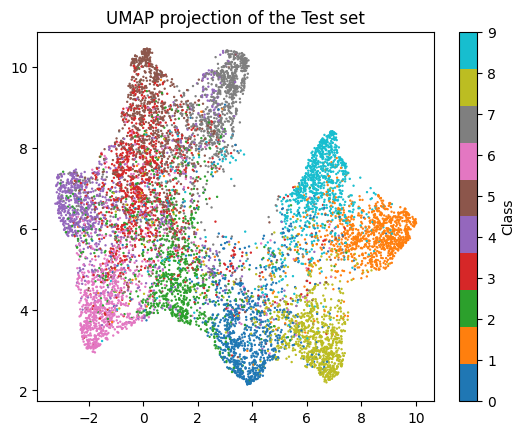

In [20]:
model.eval()
features_list = []
label_list = []

for inputs, targets in tqdm(test_loader):
    inputs = inputs.to(device)
    with torch.no_grad():
        features = model.extract_features(inputs)
    features_list.append(features.cpu())
    label_list.append(targets)

features = torch.cat(features_list)
labels = torch.cat(label_list)

plot_umap(features, labels, title="Test set")

###Q1.3 Adversarial Test (15 points)


In this section, you are required to change the unseen data before calculating the accuracy of them from the output image of the backbone. Compare the results with the previous section. Your changes should include data augmentations such as adding Gaussian noise, color jitter, etc. Additionally, you should apply an adversarial attack such as fast gradient method on the network. You can use the cleverhans library for this purpose.

In [21]:
from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method;

In [22]:
augmentation = transforms.Compose([
    transforms.ColorJitter(brightness=0.01, contrast=0.01, saturation=0.01, hue=0.01),
    transforms.Lambda(lambda x: x + torch.randn_like(x) * 0.01)
])

100%|██████████| 157/157 [00:26<00:00,  5.83it/s]


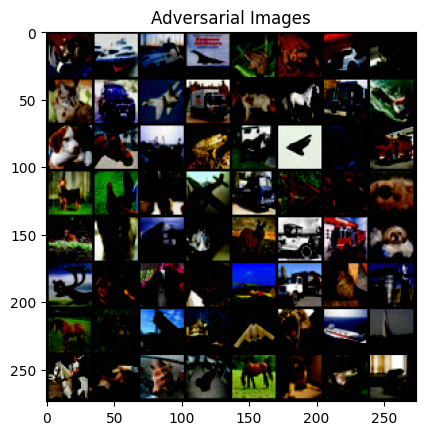

In [23]:
def generate_fgm_examples(model, data_loader) -> Tuple[torch.Tensor, torch.Tensor]:
    model.eval()
    examples = []
    labels = []

    for inputs, targets in tqdm(data_loader):
        inputs = inputs.to(device)
        inputs = augmentation(inputs)
        adv_inputs = fast_gradient_method(
            model, inputs, eps=0.01, norm=np.inf, clip_min=0.0, clip_max=1.0
        )
        examples.append(adv_inputs.detach().cpu())
        labels.append(targets)

    examples = torch.cat(examples)
    labels = torch.cat(labels)

    return examples, labels

def get_fgm_dataloader(data_x, data_y, batch_size=64, shuffle=False) -> DataLoader:
    dataset = TensorDataset(data_x, data_y)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader

advx_test, advy_test = generate_fgm_examples(model, test_loader)

# visulization
img = advx_test[0:64]
img = torchvision.utils.make_grid(img)
npimg: np.ndarray = img.numpy()
npimg = npimg.transpose(1, 2, 0)
plt.imshow(npimg)
plt.title("Adversarial Images")
plt.show()

100%|██████████| 157/157 [00:03<00:00, 40.49it/s]


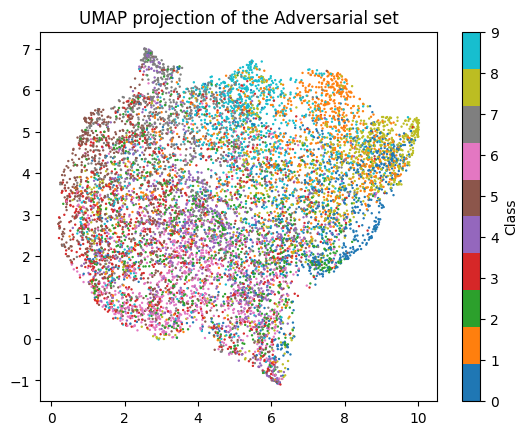

In [24]:
# attacked features

model.eval()
features_list = []
label_list = []

# initialize data loader
adv_test_loader = get_fgm_dataloader(advx_test, advy_test)

for inputs, targets in tqdm(adv_test_loader):
    inputs = inputs.to(device)
    with torch.no_grad():
        features = model.extract_features(inputs)
    features_list.append(features.cpu())
    label_list.append(targets)

features = torch.cat(features_list)
labels = torch.cat(label_list)

plot_umap(features, labels, title="Adversarial set")

In [25]:
# test the adversarial accuracy
adv_loss, adv_accuracy = test(model, adv_test_loader, criterion)
print(
    f"    Adversarial Loss: {adv_loss:.4f},\
      Adversarial Accuracy: {adv_accuracy * 100:.2f}%"
)

    test: 100%|██████████| 157/157 [00:03<00:00, 49.22it/s, accuracy=27.8, loss=5.11]

    Adversarial Loss: 4.2749,      Adversarial Accuracy: 27.83%


##Q1.4 Adversarial Train (20 points)


In this section, you should repeat the experiments on parts two and three using adversarial examples and compare the results. Here, the training data will be modified using augmentations and adversarial attack.

In [26]:
# prepare data
advx_train, advy_train = generate_fgm_examples(model, train_loader)
adv_train_loader = get_fgm_dataloader(
    advx_train, advy_train, batch_size=64, shuffle=True
)

100%|██████████| 157/157 [00:26<00:00,  5.92it/s]


In [28]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 20
epoch_range = [0, NUM_EPOCHS]

adv_model = Resnet18(num_classes=10, normalize=True).to(device)
adv_optimizer = optim.AdamW(adv_model.parameters(), lr=LEARNING_RATE)

for epoch in range(*epoch_range):
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    train_loss, train_accuracy = train(adv_model, adv_train_loader,
                                       criterion, adv_optimizer)
    print(f"    Training Loss: {train_loss:.4f},\
          Training Accuracy: {train_accuracy * 100:.2f}%")

test_loss, test_accuracy = test(adv_model, test_loader, criterion)
print("Test Set")
print(f"    Test Loss: {test_loss:.4f},\
      Test Accuracy: {test_accuracy * 100:.2f}%")

adv_test_loss, adv_test_accuracy = test(adv_model, adv_test_loader, criterion)
print("Adversarial Test Set")
print(f"    Test Loss: {adv_test_loss:.4f},\
      Test Accuracy: {adv_test_accuracy * 100:.2f}%")


Epoch 1/20


    train: 100%|██████████| 157/157 [00:09<00:00, 15.98it/s, accuracy=31.3, loss=1.36]


    Training Loss: 1.8729,          Training Accuracy: 31.32%
Epoch 2/20


    train: 100%|██████████| 157/157 [00:09<00:00, 16.11it/s, accuracy=40.5, loss=1.79]


    Training Loss: 1.6149,          Training Accuracy: 40.47%
Epoch 3/20


    train: 100%|██████████| 157/157 [00:09<00:00, 16.00it/s, accuracy=46.7, loss=1.98]


    Training Loss: 1.4558,          Training Accuracy: 46.73%
Epoch 4/20


    train: 100%|██████████| 157/157 [00:09<00:00, 15.88it/s, accuracy=50.8, loss=1.76]


    Training Loss: 1.3415,          Training Accuracy: 50.84%
Epoch 5/20


    train: 100%|██████████| 157/157 [00:10<00:00, 15.03it/s, accuracy=56.3, loss=1.28]


    Training Loss: 1.2158,          Training Accuracy: 56.32%
Epoch 6/20


    train: 100%|██████████| 157/157 [00:09<00:00, 15.95it/s, accuracy=60.1, loss=0.944]


    Training Loss: 1.1113,          Training Accuracy: 60.14%
Epoch 7/20


    train: 100%|██████████| 157/157 [00:10<00:00, 15.21it/s, accuracy=64.3, loss=1.05]


    Training Loss: 0.9957,          Training Accuracy: 64.30%
Epoch 8/20


    train: 100%|██████████| 157/157 [00:09<00:00, 16.35it/s, accuracy=68.8, loss=1]


    Training Loss: 0.8713,          Training Accuracy: 68.77%
Epoch 9/20


    train: 100%|██████████| 157/157 [00:09<00:00, 16.39it/s, accuracy=73, loss=0.858]


    Training Loss: 0.7451,          Training Accuracy: 73.04%
Epoch 10/20


    train: 100%|██████████| 157/157 [00:09<00:00, 16.26it/s, accuracy=78.7, loss=1.01]


    Training Loss: 0.6040,          Training Accuracy: 78.74%
Epoch 11/20


    train: 100%|██████████| 157/157 [00:09<00:00, 16.24it/s, accuracy=83.8, loss=0.904]


    Training Loss: 0.4484,          Training Accuracy: 83.75%
Epoch 12/20


    train: 100%|██████████| 157/157 [00:09<00:00, 16.19it/s, accuracy=88.8, loss=1.22]


    Training Loss: 0.3121,          Training Accuracy: 88.78%
Epoch 13/20


    train: 100%|██████████| 157/157 [00:09<00:00, 16.25it/s, accuracy=92.1, loss=0.433]


    Training Loss: 0.2269,          Training Accuracy: 92.12%
Epoch 14/20


    train: 100%|██████████| 157/157 [00:09<00:00, 16.36it/s, accuracy=94.3, loss=0.48]


    Training Loss: 0.1645,          Training Accuracy: 94.33%
Epoch 15/20


    train: 100%|██████████| 157/157 [00:09<00:00, 16.31it/s, accuracy=95.4, loss=0.192]


    Training Loss: 0.1359,          Training Accuracy: 95.41%
Epoch 16/20


    train: 100%|██████████| 157/157 [00:09<00:00, 15.98it/s, accuracy=96.2, loss=0.0771]


    Training Loss: 0.1090,          Training Accuracy: 96.25%
Epoch 17/20


    train: 100%|██████████| 157/157 [00:09<00:00, 16.28it/s, accuracy=97, loss=0.249]


    Training Loss: 0.0865,          Training Accuracy: 97.00%
Epoch 18/20


    train: 100%|██████████| 157/157 [00:09<00:00, 16.30it/s, accuracy=96.7, loss=0.00389]


    Training Loss: 0.1024,          Training Accuracy: 96.65%
Epoch 19/20


    train: 100%|██████████| 157/157 [00:09<00:00, 16.39it/s, accuracy=98.8, loss=0.00218]


    Training Loss: 0.0378,          Training Accuracy: 98.81%
Epoch 20/20


    train: 100%|██████████| 157/157 [00:09<00:00, 16.29it/s, accuracy=98.8, loss=0.208]


    Training Loss: 0.0365,          Training Accuracy: 98.85%


    test: 100%|██████████| 157/157 [00:05<00:00, 27.14it/s, accuracy=35, loss=4.42]


Test Set
    Test Loss: 4.6184,      Test Accuracy: 35.05%


    test: 100%|██████████| 157/157 [00:03<00:00, 50.24it/s, accuracy=58.1, loss=1.68]

Adversarial Test Set
    Test Loss: 2.2695,      Test Accuracy: 58.13%


100%|██████████| 157/157 [00:04<00:00, 31.90it/s]


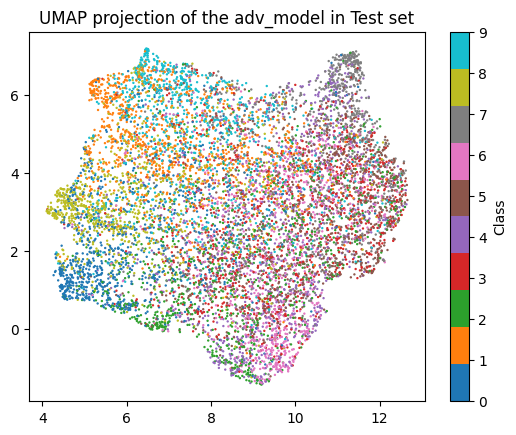

In [29]:
adv_model.eval()
features_list = []
label_list = []

for inputs, targets in tqdm(test_loader):
    inputs = inputs.to(device)
    with torch.no_grad():
        features = adv_model.extract_features(inputs)
    features_list.append(features.cpu())
    label_list.append(targets)

features = torch.cat(features_list)
labels = torch.cat(label_list)

plot_umap(features, labels, title="adv_model in Test set")

100%|██████████| 157/157 [00:02<00:00, 54.69it/s]


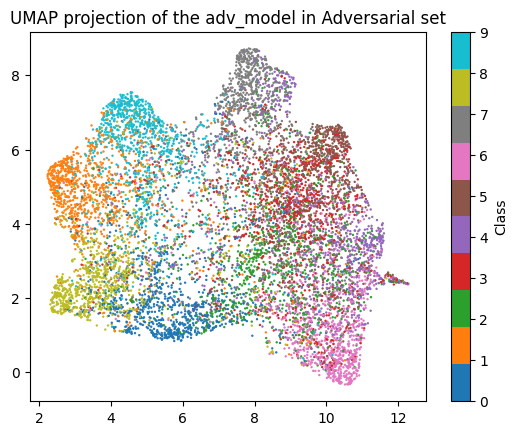

In [30]:
adv_model.eval()
features_list = []
label_list = []

for inputs, targets in tqdm(adv_test_loader):
    inputs = inputs.to(device)
    with torch.no_grad():
        features = adv_model.extract_features(inputs)
    features_list.append(features.cpu())
    label_list.append(targets)

features = torch.cat(features_list)
labels = torch.cat(label_list)

plot_umap(features, labels, title="adv_model in Adversarial set")

##Question2 - Diffusion Model (45 points)

This homework helps you implement a Denoising Diffusion Probabilistic Model (DDPM).  



You can add any extra libraries that you need in this cell.

In [ ]:
import torchvision
from torchvision import transforms
import pandas as pd
import numpy as np
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
import torch.nn as nn
from matplotlib import pyplot as plt
from PIL import Image
from keras.datasets import cifar10
!pip install diffusers
from diffusers import UNet2DModel, DDPMScheduler

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 14.8 MB/s eta 0:00:00


###Q2.1 Load Data (5 points)

In this question, you are going to use one arbitrary class of CIFAR-10 dataset. First, load this dataset, then choose any class you want and use that for the rest of this question.

In [ ]:
#Load the data and choose one class, then create the data loader.

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, images, transform=None):
        #To do
        self.images = images
        self.transform = transform


    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        #To do
        image = self.images[idx]
        if self.transform:
            image = self.transform(image)
        return  image


preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

cifar10_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=None)

# Filter for a specific class 0
class_id = 0
images_of_class = np.array([img for img, label in zip(cifar10_train.data, cifar10_train.targets) if label == class_id])

custom_dataset = CustomDataset(images_of_class, transform=preprocess)

dataloader = DataLoader(custom_dataset, batch_size=64, shuffle=True)

100%|██████████| 170498071/170498071 [00:04<00:00, 42082073.09it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
def show_images(x):
    x = x * 0.5 + 0.5
    grid = torchvision.utils.make_grid(x)
    grid = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid = Image.fromarray(np.array(grid).astype(np.uint8))
    return grid

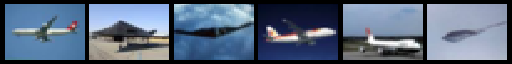

In [ ]:
x_test = next(iter(dataloader))[:6]
show_images(x_test).resize((8 * 64, 64), resample=Image.NEAREST)

###Q2.2 Forward pass (10 points)

In this section, you are going to implement the forward pass of your diffusion model. You can use diffusers library for this task. Then use show_images function to plot your target image at different times of the forward pass. (Simply use the default hypermeters mentioned in the DDPM paper or the default values of the diffuser library. Visualising images every 100 steps is enough)

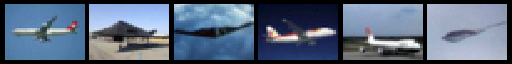

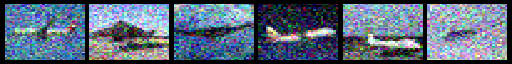

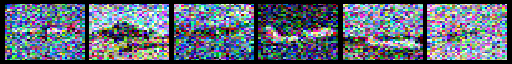

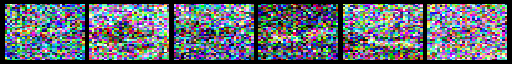

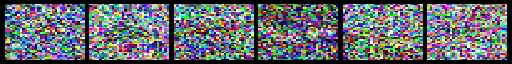

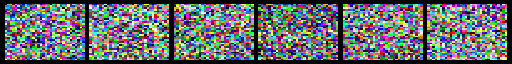

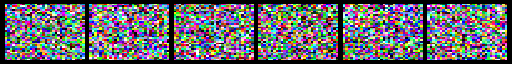

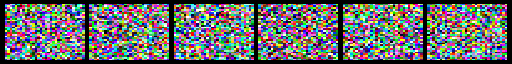

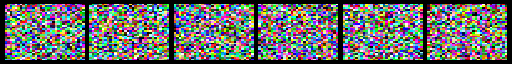

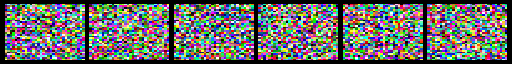

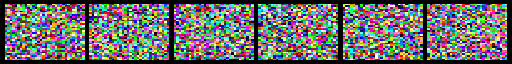

In [ ]:
def forward_pass(x, noise_scheduler, T=1000):
    images = []
    noise_scheduler.set_timesteps(T)
    for t in range(T):
      noise = torch.randn_like(x.to(device))
      timesteps = torch.tensor([t]).to(x.device)
      noisy_x = noise_scheduler.add_noise(x.to(device), noise, timesteps)
      if t % 100 == 0 or t == T - 1:
          img = show_images(noisy_x)
          display(img.resize((8 * 64, 64), resample=Image.NEAREST))

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
timesteps = torch.linspace(0, 99, 6).long().to(device)
forward_pass(x_test, noise_scheduler=noise_scheduler, T=1000)


###Q2.3 Denoising (15 points)

In this section, you will implement the denoising part of your diffusion model. First, create a U-net and train it on your CIFAR10 data. Then, start from random noise and plot the denoised images of 6 random samples. (In the DDPM paper Sec 3.3, they also trained a reverse process decoder. You are not required to implement it in this assignment. Visualizing the outputs of the diffusion network is sufficient.)

In [ ]:
model = UNet2DModel(
    sample_size=32,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(64, 128, 128, 256),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
      ),
)
model.to(device);

In [ ]:
import torch.nn.functional as F

noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2"
)

def train(model,data_loader,criterion,optimizer):
    total_loss = 0.0
    total_steps = len(data_loader)

    with tqdm(data_loader, desc ="   train") as train_tqdm:
        for batch_idx, inputs in enumerate(train_tqdm):
            model.train()
            inputs = inputs.to(device)
            #To do
            bs = inputs.size(0)
            # add noise
            noise = torch.randn(inputs.shape, device=inputs.device)
            timesteps = torch.randint(
                0, noise_scheduler.num_train_timesteps, (bs,), device=inputs.device
            ).long()
            noisy_images = noise_scheduler.add_noise(inputs, noise, timesteps)
            # compare
            noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
            loss = criterion(noise_pred, noise)
            # update weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            train_tqdm.set_description(f"train - step: {batch_idx + 1}/{total_steps}, loss: {loss.item():.4f}")

    average_train_loss = total_loss / total_steps
    return average_train_loss

optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4)
losses = []
for epoch in range(100):
    average_train_loss = train(model, dataloader, F.mse_loss, optimizer)

    if (epoch + 1) % 5 == 0:
        print(f"Epoch: {epoch + 1}, Average Training Loss: {average_train_loss:.4f}")

   train:   0%|          | 0/79 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:139: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
train - step: 79/79, loss: 0.0582: 100%|██████████| 79/79 [00:15<00:00,  5.13it/s]


Epoch: 5, Average Training Loss: 0.0636


train - step: 79/79, loss: 0.0368: 100%|██████████| 79/79 [00:15<00:00,  5.10it/s]


Epoch: 10, Average Training Loss: 0.0579


train - step: 79/79, loss: 0.0190: 100%|██████████| 79/79 [00:15<00:00,  5.11it/s]


Epoch: 15, Average Training Loss: 0.0507


train - step: 79/79, loss: 0.0777: 100%|██████████| 79/79 [00:15<00:00,  5.08it/s]


Epoch: 20, Average Training Loss: 0.0517


train - step: 79/79, loss: 0.0221: 100%|██████████| 79/79 [00:15<00:00,  5.10it/s]


Epoch: 25, Average Training Loss: 0.0502


train - step: 79/79, loss: 0.0503: 100%|██████████| 79/79 [00:15<00:00,  5.08it/s]


Epoch: 30, Average Training Loss: 0.0493


train - step: 79/79, loss: 0.0340: 100%|██████████| 79/79 [00:15<00:00,  5.13it/s]


Epoch: 35, Average Training Loss: 0.0482


train - step: 79/79, loss: 0.0168: 100%|██████████| 79/79 [00:15<00:00,  5.05it/s]


Epoch: 40, Average Training Loss: 0.0482


train - step: 79/79, loss: 0.0248: 100%|██████████| 79/79 [00:15<00:00,  5.09it/s]


Epoch: 45, Average Training Loss: 0.0487


train - step: 79/79, loss: 0.0107: 100%|██████████| 79/79 [00:15<00:00,  5.10it/s]


Epoch: 50, Average Training Loss: 0.0477


train - step: 79/79, loss: 0.1009: 100%|██████████| 79/79 [00:15<00:00,  5.11it/s]


Epoch: 55, Average Training Loss: 0.0476


train - step: 79/79, loss: 0.0347: 100%|██████████| 79/79 [00:15<00:00,  5.10it/s]


Epoch: 60, Average Training Loss: 0.0460


train - step: 79/79, loss: 0.0368: 100%|██████████| 79/79 [00:15<00:00,  5.07it/s]


Epoch: 65, Average Training Loss: 0.0478


train - step: 79/79, loss: 0.0502: 100%|██████████| 79/79 [00:15<00:00,  5.11it/s]


Epoch: 70, Average Training Loss: 0.0472


train - step: 79/79, loss: 0.0246: 100%|██████████| 79/79 [00:15<00:00,  5.06it/s]


Epoch: 75, Average Training Loss: 0.0476


train - step: 79/79, loss: 0.0490: 100%|██████████| 79/79 [00:15<00:00,  5.08it/s]


Epoch: 80, Average Training Loss: 0.0455


train - step: 79/79, loss: 0.0509: 100%|██████████| 79/79 [00:15<00:00,  5.09it/s]


Epoch: 85, Average Training Loss: 0.0446


train - step: 79/79, loss: 0.0419: 100%|██████████| 79/79 [00:15<00:00,  5.10it/s]


Epoch: 90, Average Training Loss: 0.0455


train - step: 79/79, loss: 0.0165: 100%|██████████| 79/79 [00:15<00:00,  5.07it/s]


Epoch: 95, Average Training Loss: 0.0447


train - step: 79/79, loss: 0.0744: 100%|██████████| 79/79 [00:15<00:00,  5.07it/s]

Epoch: 100, Average Training Loss: 0.0441


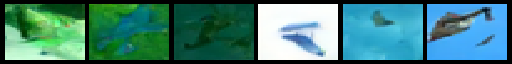

In [ ]:
sample = torch.randn(6, 3, 32, 32).to(device)

#denoise
for i, t in enumerate(noise_scheduler.timesteps):

    # model pred
    with torch.no_grad():
        residual = model(sample, t).sample
    sample = noise_scheduler.step(residual, t, sample).prev_sample

show_images(sample).resize((8 * 64, 64), resample=Image.NEAREST)


###Q2.4 Conditional Equation (15 points)

In this part, you should express $\alpha_t$ in terms of the values of $\beta_i$, in the following equation:

$$q(z_t|z_0) = \mathcal{N}(z_t; \sqrt{\alpha_t}z_0, (1-\alpha_t)I)$$

Take this into account that the conditional variance for the one step forward diffusion (the following equation) at time t is given by $\beta_t$.

$$q(z_t|z_{t-1}) = \mathcal{N}(z_t; \sqrt{1-\beta_t}z_{t-1}, \beta_tI)$$

solution:

$$\alpha_t = \prod_{i=1}^{t}  (1 - \beta_i)$$
since $$\sqrt{1 - \beta_t}$$ is the scaling factor of the previous vector $$x_{t-1}$$ and we have $$\sqrt{\alpha_t} = \sqrt{1 - \beta_t}*\sqrt{1 - \beta_{t-1}}*...*\sqrt{1 - \beta_1}$$ from $$q(z_t|z_0) = q(z_t|z_{t-1})q(z_{t-1}|z_{t-2})...q(z_1|z_0)$$